# Import the libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.io import imread_collection
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern, hessian_matrix, hessian_matrix_eigvals
from skimage.filters import gabor
from tqdm import tqdm
from skimage.transform import rotate, rescale
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from google.colab import drive

# Define the path for training, validation and testing datasets

In [2]:
drive.mount('/content/gdrive')

train_dir = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/train")
valid_dir = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/valid")
test_dir = Path("/content/gdrive/MyDrive/AI PROJECT DATASET/test")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Function to extract the features from the images (Hog, LBP, edge, shape etc.)

In [3]:
def extract_features(image_dir, batch_size=128, resize_dim=(128, 128)):
    image_collection = imread_collection(image_dir + '/*.jpg')  # images are in JPEG format
    features = []
    num_images = len(image_collection)
    num_batches = (num_images + batch_size - 1) // batch_size

    for batch_idx in tqdm(range(num_batches), desc='Extracting features'):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, num_images)
        batch_images = image_collection[start_idx:end_idx]

        batch_features = []
        for image in batch_images:
            # Resize image
            resized_image = resize(image, resize_dim)

            # Convert image to grayscale
            gray_image = rgb2gray(resized_image)

            # Extract HOG features for each image
            hog_features = hog(gray_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

            # Extract LBP features
            lbp_radius = 3
            lbp_points = 8 * lbp_radius
            lbp = local_binary_pattern(gray_image, lbp_points, lbp_radius, method='uniform')
            lbp_histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_points + 3), range=(0, lbp_points + 2))
            lbp_features = lbp_histogram.astype(np.float32)

            # Extract Gabor filter features
            gabor_filters = []
            gabor_orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            gabor_frequencies = [0.1, 0.2, 0.3, 0.4]
            for freq in gabor_frequencies:
                for theta in gabor_orientations:
                    gabor_filters.append(gabor(gray_image, frequency=freq, theta=theta))
            gabor_features = np.array([np.mean(np.abs(gabor_image)) for gabor_image in gabor_filters], dtype=np.float32)

            # Extract color histogram
            color_histogram, _ = np.histogram(resized_image.flatten(), bins=256, range=(0, 256))
            color_histogram_features = color_histogram.astype(np.float32)

            # # Extract edge features
            # edges = cv2.Canny(image,100,200)
            # edges_flat = edges.flatten()

            # # Extract shape features
            # H = hessian_matrix(image, sigma=1)
            # _, l2, _ = hessian_matrix_eigvals(H)
            # shape_features = l2.flatten().astype(np.float32)

            # Combine all features
            combined_features = np.concatenate((hog_features, lbp_features, gabor_features, color_histogram_features))
            batch_features.append(combined_features)

        features.extend(batch_features)

    return np.array(features)


#Function to extract the labels for classification

In [4]:
def extract_labels(image_dir, species):
    image_collection = imread_collection(image_dir + '/*.jpg')  # Assuming images are in JPEG format
    labels = np.full(len(image_collection), species)
    return labels

#Define the bird species list

In [5]:
# To only load this species data for classification from the provided dataset path
# Class List
species_list = ['Asian Green Bee-Eater', 'Cattle Egret', 'Hoopoe']

# Extract features and labels from the images

In [6]:
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []
y_test = []

for species_idx, species in enumerate(species_list):
    species_train_dir = train_dir / species
    species_valid_dir = valid_dir / species
    species_test_dir = test_dir / species

    species_train_features = extract_features(str(species_train_dir))
    species_valid_features = extract_features(str(species_valid_dir))
    species_test_features = extract_features(str(species_test_dir))

    species_train_labels = extract_labels(str(species_train_dir), species_idx)
    species_valid_labels = extract_labels(str(species_valid_dir), species_idx)
    species_test_labels = extract_labels(str(species_test_dir), species_idx)

    X_train.extend(species_train_features)
    y_train.extend(species_train_labels)
    X_valid.extend(species_valid_features)
    y_valid.extend(species_valid_labels)
    X_test.extend(species_test_features)
    y_test.extend(species_test_labels)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

Extracting features: 100%|██████████| 2/2 [01:02<00:00, 31.47s/it]


#Decision Tree Training

In [7]:
# Define the decision tree classifier
clf = DecisionTreeClassifier()

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'max_features': [2, 3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=2, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the decision tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=40, max_features=2, min_samples_leaf=2,
                       min_samples_split=10)

#Testing on validation dataset

In [8]:
# Predict on the validation set
y_valid_pred = clf.predict(X_valid)

# Evaluate performance metrics
accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred, average='macro')
recall = recall_score(y_valid, y_valid_pred, average='macro')
f1 = f1_score(y_valid, y_valid_pred, average='macro')

# Print evaluation metrics
print(f"Validation Set - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")


Validation Set - Accuracy: 0.5108958837772397, Precision: 0.5104027198854785, Recall: 0.5108431185866921, F1-score: 0.5080704395233271


#Testing on test dataset

In [9]:
# Predict on the testing set
y_test_pred = clf.predict(X_test)

# Evaluate performance metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

# Print evaluation metrics
print(f"Testing Set - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")


Testing Set - Accuracy: 0.4892601431980907, Precision: 0.5011190949809876, Recall: 0.4892428914011648, F1-score: 0.49052014890142637


#Confusion Matrix

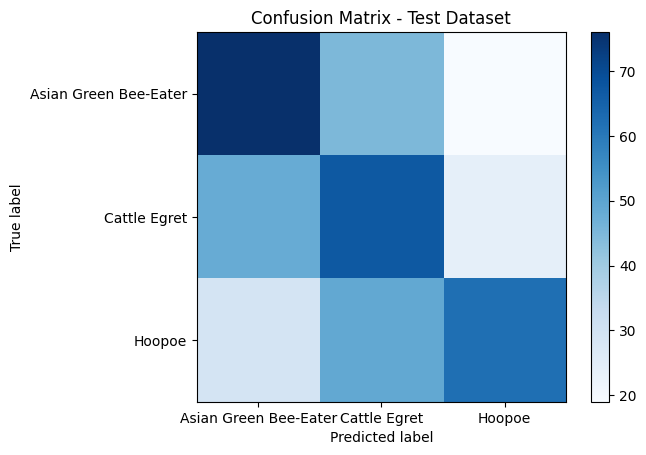

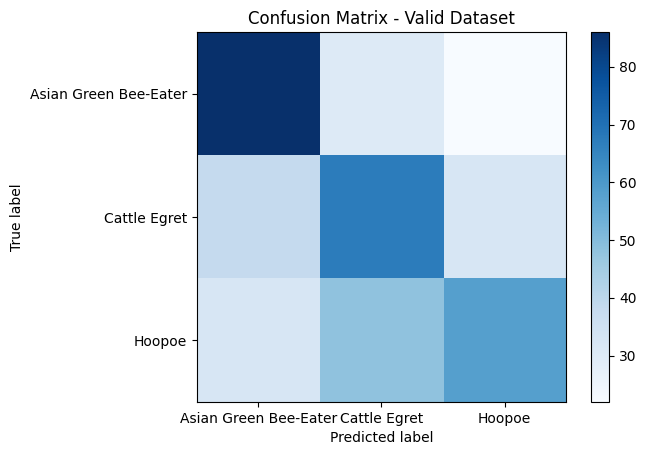

In [10]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=species_list, yticklabels=species_list, xlabel='Predicted label', ylabel='True label', title='Confusion Matrix - Test Dataset')
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=species_list, yticklabels=species_list, xlabel='Predicted label', ylabel='True label', title='Confusion Matrix - Valid Dataset')
plt.show()


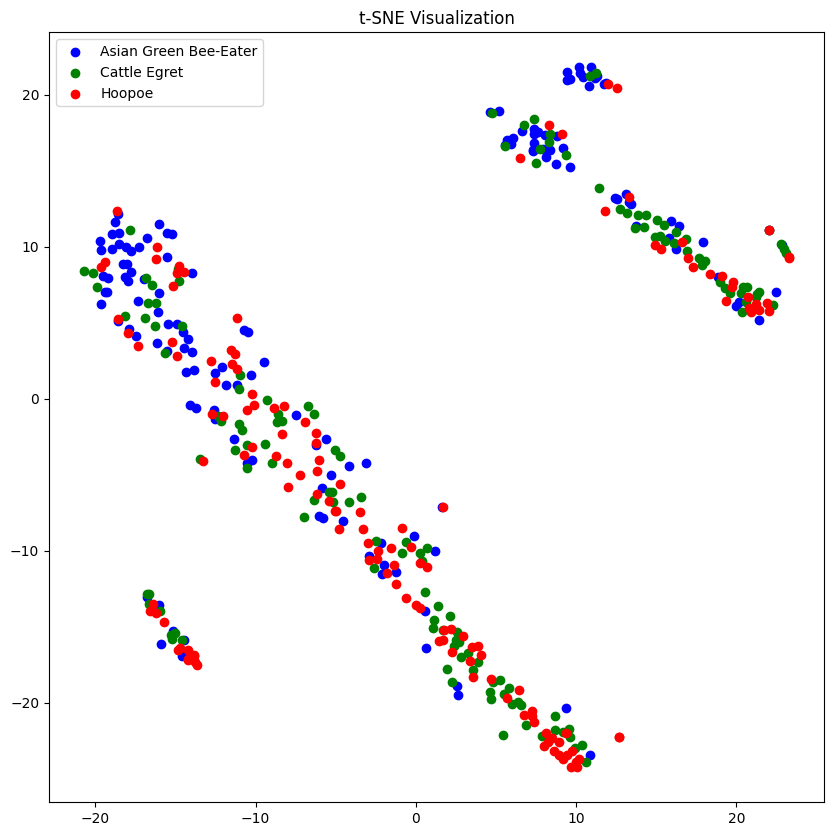

In [11]:
from sklearn.manifold import TSNE
# Perform t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_test)

# Plot t-SNE visualization
plt.figure(figsize=(10, 10))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, species in enumerate(species_list):
    idx = np.where(y_test == i)
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=colors[i], label=species)
plt.title('t-SNE Visualization')
plt.legend()
plt.show()